# Homework 2 Parts 1-3: Word2Vec

This homework will have you implementing word2vec using PyTorch and let you familiarize yourself with building more complex neural networks and the larger PyTorch development infrastructure.

Broadly, this homework consists of a few major parts:
1. Implement a `Corpus` class that will load the dataset and convert it to a sequence of token ids
2. Implement negative sampling to select tokens to be used as negative examples of words in the context
3. Create your dataset of positive and negative examples per context and load it into PyTorch's `DataLoader` to use for sampling
4. Implement a `Word2Vec` class that is a PyTorch neural network
5. Implement a training loop that samples a _batch_ of target words and their respective positive/negative context words
6. Implement rare word removal and frequent word subsampling
7. Run your model on the full dataset for at least one epoch
8. Do the exploratory parts of the homework
9. Save vectors and word-indexing data for later use in training a classifier

After Step 5, you should be able to run your word2vec implementation on a small dataset and verify that it's learning correctly. Once you can verify everything is working, proceed with steps 6 and beyond. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**

### Estimated performance times on medium dataset

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation on the medium dataset for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading and tokenizing: ~5 seconds
* Subsampling and converting to token ids: ~15 seconds
* Generating the list of training examples: ~2 minutes (~15 minutes before the random number generator fix)
* Training one epoch: ~12 minutes

In [43]:
# !pip install torch
# !pip install tqdm 
# !pip install nltk 
# !pip install gensim 
# !pip install wandb
# !pip install pandas
# !pip install seaborn 
# !pip install wandb
# !pip install scipy

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim
import gzip
import pandas as pd

import wandb
import seaborn as sns

# Helpful for computing cosine similarity--Note that this is NOT a similarity!
from scipy.spatial.distance import cosine

# Handy command-line argument parsing
import argparse

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# We'll use this to save our models
from gensim.models import KeyedVectors

import pickle

#
# IMPORTANT NOTE: Always set your random seeds when dealing with stochastic
# algorithms as it lets your bugs be reproducible and (more importantly) it lets
# your results be reproducible by others.
#
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [44]:
tokenizer = RegexpTokenizer(r'\w+')

tokenizer.tokenize(text="I am a cat")

['I', 'am', 'a', 'cat']

# Create an efficient random number generator (do this part this later)

Computers have to work to generate random numbers. However, the effort for getting those random numbers varies by how many you ask for. In practice, it's _much_ more efficient to generate many random numbers at once, rather than one at a time. 


In generating the training data for word2vec, you'll be generating a lot of random numbers. We've added a helpful class that you can use to eventually speed things up. You should use an instance of this `RandomNumberGenerator` class to generate the numbers you need (rather than using `np.random`). This class should work as a quick drop-in in its current implementation. **You should change the implementation of this class _only_ after getting the rest of your code debugged**. Once you get things working, update the code in this class so that it will create large buffers of random numbers and then when asked for a new number, read the next number from the buffer instead of calling `random` or `randint`. Essentially, this class will pre-allocate many random numbers ahead of time and then return them in order to avoid the overhead of generating them one at a time. You could see up to an ~80% performance improvement in your negatve sampling code generation as a result of this!

In [45]:
class RandomNumberGenerator:
    ''' 
    A wrapper class for a random number generator that will (eventually) hold buffers of pre-generated random numbers for
    faster access. For now, it just calls np.random.randint and np.random.random to generate these numbers 
    at the time they are needed.
    '''

    def __init__(self, buffer_size, seed=12345):
        '''
        Initializes the random number generator with a seed and a buffer size of random numbers to use

        Args:
            buffer_size: The number of random numbers to pre-generate. You will eventually want 
                         this to be a large-enough number than you're not frequently regenerating the buffer
            seed: The seed for the random number generator
        '''
        self.max_val = -1
        # TODO (later): create a random number generator using numpy and set its seed    
        # TODO (later): pre-generate a buffer of random floats to use for random()

    def random(self):
        '''
        Returns a random float value between 0 and 1
        '''
        # TODO (later): get a random number from the float buffer, rather than calling np.random.random
        # NOTE: If you reach the end of the buffer, you should refill it with new random float numbers
        return np.random.random()

    def set_max_val(self, max_val):
        '''
        Sets the maximum integer value for randint and creates a buffer of random integers
        '''
        self.max_val = max_val
        # NOTE: This default implemenation just sets the max_val and does not create a buffer of random integers
        # TODO (later): Implement a buffer of random integers (for now, we'll just use np.random.randint)

    def randint(self):
        '''
        Returns a random int value between 0 and self.max_val (inclusive)
        '''        
        if self.max_val == -1:
            raise ValueError("Need to call set_max_val before calling randint")
        
        # TODO (later): get a random number from the int buffer, rather than calling np.random.randint
        # NOTE: If you reach the end of the buffer, you should refill it with new random ints
        return np.random.randint(0, self.max_val)

## Create a class to hold the data

Before we get to training word2vec, we'll need to process the corpus into some representation. The `Corpus` class will handle much of the functionality for corpus reading and keeping track of which word types belong to which ids. The `Corpus` class will also handle the crucial functionality of generating negative samples for training (i.e., randomly-sampled words that were not in the target word's context).

Some parts of this class can be completed after you've gotten word2vec up and running, so see the notes below and the details in the homework PDF.

In [46]:
class Corpus:
    
    def __init__(self, rng, sub_sample=True):

        self.tokenizer = RegexpTokenizer(r'\w+')
        self.rng = rng

        # These state variables become populated with function calls
        #
        # 1. load_data()
        # 2. generate_negative_sampling_table()
        #
        # See those functions for how the various values get filled in

        self.word_to_index = {} # word to unique-id
        self.index_to_word = {} # unique-id to word

        # How many times each word occurs in our data after filtering
        self.word_counts = Counter()

        # A utility data structure that lets us quickly sample "negative"
        # instances in a context. This table contains unique-ids
        self.negative_sampling_table = []
        
        # The dataset we'll use for training, as a sequence of unqiue word
        # ids. This is the sequence across all documents after tokens have been
        # randomly subsampled by the word2vec preprocessing step
        self.full_token_sequence_as_ids = None
        
        self.sub_sample = sub_sample
        
    def tokenize(self, text):
        '''
        Tokenize the document and returns a list of the tokens
        '''
        return self.tokenizer.tokenize(text)        

    def load_data(self, file_name, min_token_freq):
        '''
        Reads the data from the specified file as long long sequence of text
        (ignoring line breaks) and populates the data structures of this
        word2vec object.
        '''
        
        with open(file_name, 'r') as f:
            l = f.readlines()  

        # Step 1: Read in the file and create a long sequence of tokens for
        # all tokens in the file
        all_tokens = []
        print('Reading data and tokenizing')
        for line in l:
            tokens = self.tokenizer.tokenize(line)
            all_tokens.extend(tokens)
    
        # Step 2: Count how many tokens we have of each type
        print('Counting token frequencies')
        token_counts = dict(Counter(all_tokens))

        # Step 3: Replace all tokens below the specified frequency with an <UNK>
        # token. 
        #
        # NOTE: You can do this step later if needed
        
        print("Performing minimum thresholding")
        tokens_to_replace = {token for token, count in token_counts.items() if count < min_token_freq}
        filtered_tokens = [token if token not in tokens_to_replace else "<UNK>" for token in all_tokens]



        # Step 4: update self.word_counts to be the number of times each word
        # occurs (including <UNK>)
        self.word_counts = dict(Counter(filtered_tokens))
        # print("UNK", self.word_counts['<UNK>'])

        
        # Step 5: Create the mappings from word to unique integer ID and the
        # reverse mapping.
        
        # Create word_to_index and index_to_word mappings

        unique_words = list(self.word_counts.keys())
        self.word_to_index = {word: i for i, word in enumerate(unique_words)}
        self.index_to_word = {i: word for word, i in self.word_to_index.items()}
        self.full_token_sequence_as_ids = [self.word_to_index[token] for token in filtered_tokens]
        
        # Step 6: Compute the probability of keeping any particular *token* of a
        # word in the training sequence, which we'll use to subsample. This subsampling
        # avoids having the training data be filled with many overly common words
        # as positive examples in the context
   
                        
        # Step 7: process the list of tokens (after min-freq filtering) to fill
        # a new list self.full_token_sequence_as_ids where 
        #
        # (1) we probabilistically choose whether to keep each *token* based on the
        # subsampling probabilities (note that this does not mean we drop
        # an entire word!) and 
        #
        # (2) all tokens are convered to their unique ids for faster training.
        #
        # NOTE: You can skip the subsampling part and just do step 2 to get
        # your model up and running.
            
        # NOTE 2: You will perform token-based subsampling based on the probabilities in
        # word_to_sample_prob. When subsampling, you are modifying the sequence itself 
        # (like deleting an item in a list). This action effectively makes the context
        # window  larger for some target words by removing context words that are common
        # from a particular context before the training occurs (which then would now include
        # other words that were previously just outside the window).

        if self.sub_sample:
            t = 0.001
            total_words = sum(self.word_counts.values())
            
            # Raw word probability
            raw_word_probs = {self.word_to_index[word]: count / total_words for word, count in self.word_counts.items()}
            
            # Adjusted weight
            word2prob = {word: (np.sqrt(probs / t) + 1) * (t / probs) 
                                  for word, probs in raw_word_probs.items()}
            
            #print(word2prob)
            
            
            # Subsample based on weight
            subsampled = []
            for t in self.full_token_sequence_as_ids:
                if word2prob[t] > np.random.random():
                    subsampled.append(t)   

                
            self.full_token_sequence_as_ids = subsampled
        
        

        # Helpful print statement to verify what you've loaded
        print('Loaded all data from %s; saw %d tokens (%d unique)' \
              % (file_name, len(self.full_token_sequence_as_ids),
                 len(self.word_to_index)))
        
    def generate_negative_sampling_table(self, exp_power=0.75, table_size=1e6):
        '''
        Generates a big list data structure that we can quickly randomly index into
        in order to select a negative training example (i.e., a word that was
        *not* present in the context). 
        '''       
        
        words = np.array(list(self.word_to_index.values()))
        freqs = np.array(list(self.word_counts.values()))
        weights = np.power(freqs, exp_power)
        sum_weights = np.sum(weights)
        probs = weights / sum_weights
    
        
        # Step 1: Figure out how many instances of each word need to go into the
        # negative sampling table. 
        #
        # HINT: np.power and np.fill might be useful here        
        print("Generating sampling table")
        samples_per_word = probs * table_size

        # Step 2: Create the table to the correct size. You'll want this to be a
        # numpy array of type int
        adjusted_table_size = int(np.sum(np.floor(samples_per_word)))


        # Step 3: Fill the table so that each word has a number of IDs
        # proportionate to its probability of being sampled.
        #
        # Example: if we have 3 words "a" "b" and "c" with probabilites 0.5,
        # 0.33, 0.16 and a table size of 6 then our table would look like this
        # (before converting the words to IDs):
        #
        # [ "a", "a", "a", "b", "b", "c" ]
        #
        
        sampling_table = []
        for word_idx, samples in enumerate(samples_per_word):
            count = int(np.round(samples))
            sampling_table.extend([word_idx]*count)
        
        self.negative_sampling_table = np.array(sampling_table)
        
        
        pass


    def generate_negative_samples(self, cur_context_word_id, num_samples):
        '''
        Randomly samples the specified number of negative samples from the lookup
        table and returns this list of IDs as a numpy array. As a performance
        improvement, avoid sampling a negative example that has the same ID as
        the current positive context word.
        '''
        #print("getting negative samples")
        results = []

        # Create a list and sample from the negative_sampling_table to
        # grow the list to num_samples, avoiding adding a negative example that
        # has the same ID as the current context_word
        while len(results) < num_samples:
            rand_number = np.random.randint(0, len(self.negative_sampling_table))
            sampled = self.negative_sampling_table[rand_number]
            if sampled != cur_context_word_id:
                results.append(sampled)
        return np.array(results)

    


## Create the corpus

Now that we have code to turn the text into training data, let's do so. We've provided several files for you to help:

* `reviews-word2vec.tiny.txt` -- use this to debug your corpus reader
* `reviews-word2vec.med.txt` -- use this to debug/verify the whole word2vec works
* `reviews-word2vec.large.txt.gz` -- use this when everything works to generate your vectors for later parts
* `reviews-word2vec.HUGE.gz` -- _do not use this_ unless (1) everything works and (2) you really want to test/explore. This file is not needed at all to do your homework.

We recommend starting to debug with the first file, as it is small and fast to load (quicker to find bugs). When debugging, we recommend setting the `min_token_freq` argument to 2 so that you can verify that part of the code is working but you still have enough word types left to test the rest.

You'll use the remaining files later, where they're described.

In the next cell, create your `Corpus`, read in the data, and generate the negative sampling table.

In [47]:
corpus = Corpus(rng=RandomNumberGenerator, sub_sample=True)
corpus.load_data(file_name="reviews-word2vec.tiny.txt", min_token_freq=5)
corpus.generate_negative_sampling_table()

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from reviews-word2vec.tiny.txt; saw 10910 tokens (557 unique)
Generating sampling table


## Generate the training data

Once we have the corpus ready, we need to generate our training dataset. Each instance in the dataset is a target word and positive and negative examples of contexts words. Given the target word as input, we'll want to predict (or not predict) these positive and negative context words as outputs using our network. Your task here is to create a python `list` of instances. 

Your final training data should be a list of tuples in the format ([target_word_id], [word_id_1, ...], [predicted_labels]), where each item in the list is a list:
1. The first item is a list consisting only of the target word's ID.
2. The second item is a list of word ids for both context words and negative samples 
3. The third item is a list of labels to predicted for each of the word ids in the second list (i.e., `1` for context words and `0` for negative samples). 

You will feed these tuples into the PyTorch `DatasetLoader` later that will do the converstion to `Tensor` objects. You will need to make sure that all of the lists in each tuple are `np.array` instances and are not plain python lists for this `Tensor` converstion to work.

In [48]:
def gen_training_data(corpus, window_size=2, num_negative_samples_per_target=2):
    unk = corpus.word_to_index['<UNK>']
    filtered_list = [x for x in corpus.full_token_sequence_as_ids if x != unk]
    len_corpus = len(filtered_list)
    max_words = window_size*2  + (num_negative_samples_per_target*(window_size)*2)
    
    training_data = []

    for target_index, target_word_id in enumerate(tqdm(filtered_list)):

        positive_ids = []
        neg_ids = []
        
        # define windows
        window_start = max(target_index - window_size, 0)
        window_end = min(target_index + window_size + 1, len(filtered_list))
        
        # positive ids
        for context_index in range(window_start, window_end):
            if context_index != target_index:  
                positive_ids.append(filtered_list[context_index])
        
        # negative_ids
        neg_ids.extend(corpus.generate_negative_samples(target_word_id, num_negative_samples_per_target*len(positive_ids)))
        
        # Combine positive and negative IDs and their corresponding labels        
        total_ids = len(positive_ids) + len(neg_ids)
        gap = max_words - total_ids
        if gap > 0:
            extra_neg_ids = corpus.generate_negative_samples(target_word_id, gap) 
            neg_ids.extend(extra_neg_ids)
        
        all_ids = positive_ids + neg_ids
        labels = [1] * len(positive_ids) + [0] * len(neg_ids)  
        
        instance = (np.array([target_word_id]), np.array(all_ids), np.array(labels))
        training_data.append(instance)
    
    return training_data

In [49]:
td = gen_training_data(corpus)

print("INSPECTING TRAINING DATA")
print(td[0])
print()

print("MAKE SURE MAX TARGET ID EQUAL TO 1- LEN(VOCAB)")
targets = [max(td[i][1]) for i in range(len(td))]
print("max target id", max(targets))
print("len vocab", len(corpus.word_to_index))

assert max(targets)==len(corpus.word_to_index)-1, "ERROR: Indexing messed up"

  0%|          | 0/10511 [00:00<?, ?it/s]

INSPECTING TRAINING DATA
(array([0]), array([  2,   5, 197, 549, 371, 313, 235,  21, 212,  17,  18,   5]), array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

MAKE SURE MAX TARGET ID EQUAL TO 1- LEN(VOCAB)
max target id 556
len vocab 557


## Create the network

We'll create a new neural network as a subclass of `nn.Module` like we did in Homework 1. However, _unlike_ the network you built in Homework 1, we do not need to used linear layers to implement word2vec. Instead, we will use PyTorch's `Emedding` class, which maps an index (e.g., a word id in this case) to an embedding. 

Roughly speaking, word2vec's network makes a prediction by computing the dot product of the target word's embedding and a context word's embedding and then passing this dot product through the sigmoid function ($\sigma$) to predict the probability that the context word was actually in the context. The homework write-up has lots of details on how this works. Your `forward()` function will have to implement this computation.

In [50]:
class Word2Vec(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        
        # Save what state you want and create the embeddings for your
        # target and context words
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        
        self.target_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size)
        
        # Initialize embeddings with non-zero random numbers
        self.init_emb(init_range=0.5/self.vocab_size)
        
    def init_emb(self, init_range):
        
        # Fill your two embeddings with random numbers uniformly sampled
        # between +/- init_range
    
        self.target_embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)
        pass
        
    def forward(self, target_word_id, context_word_ids):
        ''' 
        Predicts whether each context word was actually in the context of the target word.
        The input is a tensor with a single target word's id and a tensor containing each
        of the context words' ids (this includes both positive and negative examples).
        '''
        
        # NOTE 1: This is probably the hardest part of the homework, so you'll
        # need to figure out how to do the dot-product between embeddings and return
        # the sigmoid. Be prepared for lots of debugging. For some reference,
        # our implementation is three lines and really the hard part is just
        # the last line. However, it's usually a matter of figuring out what
        # that one line looks like that ends up being the hard part.
        
        # NOTE 2: In this homework you'll be dealing with *batches* of instances
        # rather than a single instance at once. PyTorch mostly handles this
        # seamlessly under the hood for you (which is very nice) but batching
        # can show in weird ways and create challenges in debugging initially.
        # For one, your inputs will get an extra dimension. So, for example,
        # if you have a batch size of 4, your input for target_word_id will
        # really be 4 x 1. If you get the embeddings of those targets,
        # it then becomes 4x50! The same applies to the context_word_ids, except
        # that was alreayd a list so now you have things with shape 
        #
        #    (batch x context_words x embedding_size)
        #
        # One of your tasks will be to figure out how to get things lined up
        # so everything "just works". When it does, the code looks surprisingly
        # simple, but it might take a lot of debugging (or not!) to get there.
        
        # NOTE 3: We *strongly* discourage you from looking for existing 
        # implementations of word2vec online. Sadly, having reviewed most of the
        # highly-visible ones, they are actually wrong (wow!) or are doing
        # inefficient things like computing the full softmax instead of doing
        # the negative sampling. Looking at these will likely leave you more
        # confused than if you just tried to figure it out yourself.
        
        # NOTE 4: There many ways to implement this, some more efficient
        # than others. You will want to get it working first and then
        # test the timing to see how long it takes. As long as the
        # code works (vector comparisons look good) you'll receive full
        # credit. However, very slow implementations may take hours(!)
        # to converge so plan ahead.
        
        
        # Hint 1: You may want to review the mathematical operations on how
        # to compute the dot product to see how to do these
        
        target_embeddings = self.target_embeddings.weight[target_word_ids]  
        context_embeddings = self.context_embeddings.weight[context_word_ids]  
        preds = torch.sigmoid(torch.bmm(target_embeddings, context_embeddings.transpose(1, 2) )).squeeze()


    
        return preds
        


## Train the network!

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The trainin code will look surprisingly similar at times to your pytorch code from Homework 1 since all networks share the same base training setup. However, we'll add a few new elements to get you familiar with more common training techniques. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

Two new elements show up. First, we'll be using `DataLoader` which is going to sample data for us and put it in a batch (and also convert the data to `Tensor` objects. You can iterate over the batches and each iteration will return all the items eventually, one batch at a time (a full epoch's worth).

The second new part is using `wandb`. As you might have noticed in Homework 1, training neural models can take some time. [Weights & Biases](https://wandb.ai/) is a handy web-based view that you can check during training to see how the model is doing. We'll use it here and periodically log a running sum of the loss after a set number of steps. The Homework write up has a plot of what this looks like. We'll be doing something simple here with wandb but it will come in handy later as you train larger models (for longer) and may want to visually check if your model is converging and is [easy to integrate](https://docs.wandb.ai/guides/integrations/pytorch).

Once you get the code working, to start training, we recommend training on the `reviews-word2vec.med.txt` dataset. This data is small enough you can get through an epoch in a few minutes (or less) while still being large enough you can test whether the model is learning anything by examining common words. Below this cell we've added a few helper functions that you can use to debug and query your model. In particular, the `get_neighbors()` function is a great way to test: if your model has learned anything, the nearest neighbors for common words should seem reasonable (without having to jump through mental hoops). An easy word to test on the `med` data is "january" which should return month-related words as being most similar.

**NOTE**: Since we're training biographies, the text itself will be skewed towards words likely to show up biographices--which isn't necessary like "regular" text. You may find that your model has few instances of words you think are common, or that the model learns poor or unusual neighbors for these. When querying the neighbors, it can help to think of which words you think are likely to show up in biographies on Wikipedia and use those as probes to see what the model has learned.

Once you're convinced the model is learning, switch to the `med` data and train your model as specified in the PDF. Once trained, save your model using the `save()` function at the end of the notebook. This function records your data in a common format for word2vec vectors and lets you load the vectors into other libraries that have more advanced functionality. In particular, you can use the [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) code in other notebook included to explore the vectors and do simple vector analogies.

In [37]:
import os 
import pickle 


##########################
# DATA
##########################

process_med = True

# TINY DATA
print("****PROCESSING TINY DATA****")
corpus_s = Corpus(rng=RandomNumberGenerator)
corpus_s.load_data(file_name="reviews-word2vec.tiny.txt", min_token_freq=5)
print("STATUS: Loaded data")
corpus_s.generate_negative_sampling_table()
print("STATUS: Loaded negative sampling data")
print("STATUS: Starting training data generation at time", time.time())
training_data_s = gen_training_data(corpus_s)
print("STATUS: Finished training data generation at time", time.time())


# MED DATA
if process_med:
    print("****PROCESSING MED DATA****")
    corpus = Corpus(rng=RandomNumberGenerator)
    corpus.load_data(file_name="reviews-word2vec.med.txt", min_token_freq=5)
    print("STATUS: Loaded data")
    corpus.generate_negative_sampling_table()
    print("STATUS: Loaded negative sampling data")
    print("STATUS: Starting training data generation at time", time.time())
    training_data = gen_training_data(corpus)
    print("STATUS: Finished training data generation at time", time.time())
# with open("med_train.pkl", 'rb') as file:
#     training_data = pickle.load(file)


****PROCESSING TINY DATA****
Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from reviews-word2vec.tiny.txt; saw 10825 tokens (557 unique)
STATUS: Loaded data
Generating sampling table
STATUS: Loaded negative sampling data
STATUS: Starting training data generation at time 1709400404.83675


  0%|          | 0/10489 [00:00<?, ?it/s]

STATUS: Finished training data generation at time 1709400405.2539997
****PROCESSING MED DATA****
Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from reviews-word2vec.med.txt; saw 7754070 tokens (35193 unique)
STATUS: Loaded data
Generating sampling table
STATUS: Loaded negative sampling data
STATUS: Starting training data generation at time 1709400418.1725476


  0%|          | 0/7704475 [00:00<?, ?it/s]

STATUS: Finished training data generation at time 1709400691.1898472


In [38]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

##########################
# CHECK DEVICE
##########################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##########################
# PARAMETERS
##########################
early_stop = False
batch_size = 128
embedding_size = 50  
learning_rate = 1e-4  
window_size = 2  
min_token_freq = 5
epochs = 2
optimizer_choice = AdamW


##########################
# MODEL
##########################
use_med = True

if not use_med:
    model = Word2Vec(vocab_size=len(corpus_s.word_to_index), embedding_size=embedding_size).to(device)
    data_loader = DataLoader(training_data_s, batch_size=batch_size, shuffle=True, num_workers=min(os.cpu_count()-2, 20))
elif use_med:
    model = Word2Vec(vocab_size=len(corpus.word_to_index), embedding_size=embedding_size).to(device)
    data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True,num_workers=min(os.cpu_count()-2, 20))
    
optimizer = optimizer_choice(lr=learning_rate, params=model.parameters())
loss_fn = torch.nn.BCELoss()


##########################
# TRAINING
##########################

### INIT LOGGING ### 
wandb.init(project='medium_run_very_fast_128_BLAH', name='medium_run_very_fast_128_BLAH')
start_time = time.time()
print("start time", start_time)

### KEEP TRACK ###
loss_data = []
total_step = 0
loss_sum = 0

model.train()
for epoch in range(epochs):
    epoch_step = 0
    for step, data in enumerate(tqdm(data_loader)):
        
        target_word_ids, context_ids, labels = data
        
        target_word_ids = target_word_ids.to(device)
        context_ids = context_ids.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()

        preds = model(target_word_ids, context_ids)
        loss = loss_fn(preds,labels)
        
        loss.backward()
        optimizer.step()
        total_step += 1
        epoch_step +=1 
    
   
        
        loss_sum += loss.item()
        
        if (step) % 100 == 0:
            wandb.log({"loss last 100 steps": loss_sum})
            #print(time.time())
            #print(f"step {epoch_step}, epoch {epoch} (total steps = {total_step}): {loss_sum}")
            loss_data.append({'epoch':epoch, 'loss':loss.item(), 'epoch_step':epoch_step, 'total_step':total_step})
            loss_sum = 0
        if early_stop:
            if total_step > early_stop:
                print("BREAKING")
                break
print("DONE")
end_time = time.time()
print("end time", end_time)


##########################
# PLOTS
##########################
model.eval()
# loss_df = pd.DataFrame(loss_data)
#sns.lineplot(data=loss_df, x='total_step', y='loss')

Using device: cuda


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss last 100 steps,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss last 100 steps,52.87088


start time 1709400708.9046736


  0%|          | 0/60192 [00:05<?, ?it/s]

  0%|          | 0/60192 [00:05<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1472591e58b0>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1472591e58b0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x1472591e58b0>Exception ignored in: 
  File "/home/jashkina/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x1472591e58b0>Traceback (most recent call last):
  File "/home/jashkina/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/home/jashkina/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

self._shutdown_workers()
    Traceback (most recent call last):
  File "/home/jashkina/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    s

DONE
end time 1709401264.2742


Word2Vec(
  (target_embeddings): Embedding(35193, 50)
  (context_embeddings): Embedding(35193, 50)
)

## Verify things are working

Once you have an initial model trained, try using the following code to query the model for what are the nearest neighbor of a word. This code is intended to help you debug

In [39]:
# I had to change things a bit to get this working with GPU, mostly just correctly moving stuff to correct device

def get_neighbors(model, word_to_index, target_word):
    """ 
    Finds the top 10 most similar words to a target word
    """
    outputs = []
    for word, index in tqdm(word_to_index.items(), total=len(word_to_index)):
        similarity = compute_cosine_similarity(model, word_to_index, target_word, word)
        result = {"word": word, "score": similarity}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:11]

def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    '''
    Computes the cosine similarity between the two words
    
    '''
    device = next(model.parameters()).device  

    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]))
    similarity = 1 - abs(float(cosine(embedding_one.detach().squeeze().numpy(),
                                      embedding_two.detach().squeeze().numpy())))
    return similarity


def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    device = next(model.parameters()).device  
    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]).to(device))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]).to(device))

    similarity = 1 - abs(float(cosine(embedding_one.detach().squeeze().cpu().numpy(),
                                      embedding_two.detach().squeeze().cpu().numpy())))
    return similarity


In [40]:
#1
get_neighbors(model, corpus.word_to_index, "man")

  0%|          | 0/35193 [00:00<?, ?it/s]

[{'word': 'woman', 'score': 0.9894148707389832},
 {'word': 'girl', 'score': 0.9379229545593262},
 {'word': 'boy', 'score': 0.9045149087905884},
 {'word': 'dog', 'score': 0.9029589295387268},
 {'word': 'named', 'score': 0.8983724117279053},
 {'word': 'business', 'score': 0.8923181295394897},
 {'word': 'lady', 'score': 0.8908075094223022},
 {'word': 'system', 'score': 0.8904486298561096},
 {'word': 'officer', 'score': 0.888328492641449},
 {'word': 'career', 'score': 0.8880956172943115}]

In [41]:
fn = "128_y_mod_BLAH"

def save(model, corpus, filename):
    '''
    Saves the model to the specified filename as a gensim KeyedVectors in the
    text format so you can load it separately.
    '''

    kv = KeyedVectors(vector_size=model.embedding_size)        
    vectors = []
    words = []
    device = model.target_embeddings.weight.device  

    for index in trange(model.target_embeddings.num_embeddings):
        word = corpus.index_to_word[index]
        index_tensor = torch.LongTensor([index]).to(device)  
        vector = model.target_embeddings(index_tensor).detach().cpu().numpy()[0]  
        vectors.append(vector)
        words.append(word)

    kv.add_vectors(words, vectors) 
    kv.save_word2vec_format(filename, binary=False)



save(model, corpus, fn)

  0%|          | 0/35193 [00:00<?, ?it/s]

# Save your vectors / data for the pytorch classifier in Part 4!

We'll be to using these vectors later in Part 4. We want to save them in a format that PyTorch can easily use. In particular you'll need to save the _state dict_ of the embeddings, which captures all of its information. 

In [42]:
def save_embeddings(model, fn):
    torch.save(model.state_dict(), fn+".pth")
    
def save_corpus_data(corpus, fn):
    with open(f"{fn}_word2idx", 'wb') as pickle_file:
        pickle.dump(corpus.word_to_index, pickle_file)
    
    with open(f"{fn}_idx2word", 'wb') as pickle_file:
        pickle.dump(corpus.index_to_word, pickle_file)
        
save_embeddings(model, fn)
save_corpus_data(corpus, fn)

We will also need the mapping from word to index so we can figure out which embedding to use for different words. Save the `corpus` objects mapping to a file using your preferred format (e.g., pickle or json).

# Batch Experiments

## Read in

In [51]:
import os 
import pickle 


##########################
# DATA
##########################

process_med = True

# TINY DATA
print("****PROCESSING TINY DATA****")
corpus_s = Corpus(rng=RandomNumberGenerator)
corpus_s.load_data(file_name="reviews-word2vec.tiny.txt", min_token_freq=5)
print("STATUS: Loaded data")
corpus_s.generate_negative_sampling_table()
print("STATUS: Loaded negative sampling data")
print("STATUS: Starting training data generation at time", time.time())
training_data_s = gen_training_data(corpus_s)
print("STATUS: Finished training data generation at time", time.time())


# MED DATA
if process_med:
    print("****PROCESSING MED DATA****")
    corpus = Corpus(rng=RandomNumberGenerator)
    corpus.load_data(file_name="reviews-word2vec.med.txt", min_token_freq=5)
    print("STATUS: Loaded data")
    corpus.generate_negative_sampling_table()
    print("STATUS: Loaded negative sampling data")
    print("STATUS: Starting training data generation at time", time.time())
    training_data = gen_training_data(corpus)
    print("STATUS: Finished training data generation at time", time.time())
# with open("med_train.pkl", 'rb') as file:
#     training_data = pickle.load(file)


****PROCESSING TINY DATA****
Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from reviews-word2vec.tiny.txt; saw 10864 tokens (557 unique)
STATUS: Loaded data
Generating sampling table
STATUS: Loaded negative sampling data
STATUS: Starting training data generation at time 1709416001.0333078


  0%|          | 0/10526 [00:00<?, ?it/s]

STATUS: Finished training data generation at time 1709416001.4391212
****PROCESSING MED DATA****
Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from reviews-word2vec.med.txt; saw 7755514 tokens (35193 unique)
STATUS: Loaded data
Generating sampling table
STATUS: Loaded negative sampling data
STATUS: Starting training data generation at time 1709416014.47866


  0%|          | 0/7705646 [00:00<?, ?it/s]

STATUS: Finished training data generation at time 1709416290.1021683


## Run and then stop to get  batch expectations

(2, 220)
(8, 53)
(32, 15)
(64, 6)
(128, 3.5)
(256, 2.4)
(512, 0.8)

In [60]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

##########################
# CHECK DEVICE
##########################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##########################
# PARAMETERS
##########################
batch_size = 512

early_stop = False
embedding_size = 50  
learning_rate = 1e-4  
window_size = 2  
min_token_freq = 5
epochs = 2
optimizer_choice = AdamW


##########################
# MODEL
##########################
use_med = True

if not use_med:
    model = Word2Vec(vocab_size=len(corpus_s.word_to_index), embedding_size=embedding_size).to(device)
    data_loader = DataLoader(training_data_s, batch_size=batch_size, shuffle=True, num_workers=min(os.cpu_count()-2, 20))
elif use_med:
    model = Word2Vec(vocab_size=len(corpus.word_to_index), embedding_size=embedding_size).to(device)
    data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True,num_workers=min(os.cpu_count()-2, 20))
    
optimizer = optimizer_choice(lr=learning_rate, params=model.parameters())
loss_fn = torch.nn.BCELoss()


##########################
# TRAINING
##########################

### INIT LOGGING ### 
#wandb.init(project='medium_run_very_fast_128_BLAH', name='medium_run_very_fast_128_BLAH')
start_time = time.time()
print("start time", start_time)

### KEEP TRACK ###
loss_data = []
total_step = 0
loss_sum = 0

model.train()
for epoch in range(epochs):
    epoch_step = 0
    for step, data in enumerate(tqdm(data_loader)):
        
        target_word_ids, context_ids, labels = data
        
        target_word_ids = target_word_ids.to(device)
        context_ids = context_ids.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()

        preds = model(target_word_ids, context_ids)
        loss = loss_fn(preds,labels)
        
        loss.backward()
        optimizer.step()
        total_step += 1
        epoch_step +=1 
    
   
        
        loss_sum += loss.item()
        
        if (step) % 100 == 0:
            #wandb.log({"loss last 100 steps": loss_sum})
            #print(time.time())
            #print(f"step {epoch_step}, epoch {epoch} (total steps = {total_step}): {loss_sum}")
            loss_data.append({'epoch':epoch, 'loss':loss.item(), 'epoch_step':epoch_step, 'total_step':total_step})
            loss_sum = 0
        if early_stop:
            if total_step > early_stop:
                print("BREAKING")
                break
print("DONE")
end_time = time.time()
print("end time", end_time)


##########################
# PLOTS
##########################
model.eval()
# loss_df = pd.DataFrame(loss_data)
#sns.lineplot(data=loss_df, x='total_step', y='loss')

Using device: cuda
start time 1709416686.1872559


  0%|          | 0/15051 [00:08<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Time to compute an epoch')

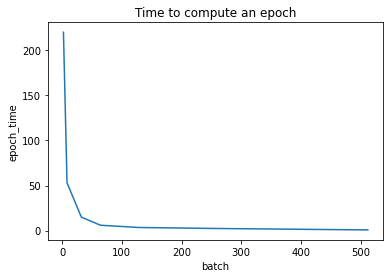

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
data = [(2, 220), (8, 53), (32, 15), (64, 6), (128, 3.5), (256, 2.4), (512, 0.8)]
df = pd.DataFrame(data)
df.columns = ['batch', 'epoch_time']
df['log_batch'] = np.log(df['batch'])

sns.lineplot(data=df, x='batch', y='epoch_time')
plt.title("Time to compute an epoch")